# Applied Programming Coding Challenge #1

![title](../img/photo-1533788179956-82e8a027c962.jpg)

## 0 General Information

### 0.1 Data Set and Features

The project [Bike Sharing Dataset](https://www.kaggle.com/lakshmi25npathi/bike-sharing-dataset) contains two data sets
* day.csv
* hour.csv

Both shall be used to predict demand of bikes using regression.
  
There are 16 (17 respectively) features in each of the two data sets
* ```instant``` Unique ID of a record
* Features describing time
  * ```dteday``` Date, e.g. 01.01.2011
  * ```season``` Numerically encoded season, e.g. 1 (=spring)
  * ```yr``` Year after start (Jan 1 2011), e.g. 0
  * ```mnth``` Month of the year, e.g. 1 (=January)
  * ```hour``` Hour of the day
  * ```holiday``` Indicator whether the day is a public holiday, e.g. 0 (=no)
  * ```weekday``` Numerically encoded weekday of the date, e.g. 0 (=Sunday)
  * ```workingday```  Indicator whether the day is a working day, e.g. 0 (=no)
* Features describing weather
  * ```weathersit``` Numerically encoded weather situation, e.g.
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  * ```temp``` Normalized temperature in Celsius
  * ```atemp``` Normalized _feeling_ temperature in Celsius
  * ```hum``` Normalized humidity
  * ```windspeed``` Normalized wind speed
* Features describing rented bikes
  * ```casual``` Number of casual users
  * ```registered``` Number of registered users
  * ```cnt``` Combined number of casual and registered users

Some features are already normalized
* ```temp```
* ```atemp```
* ```hum```
* ```windspeed```

### 0.2 Python classes being used

In the course of this notebook different setups will be trained, evaluated and compared with each other.
Therefore the following classes will be used

* ```DataSet``` representing the two data sets _day_ and _hour_
* ```Variant``` representing different variants two be compared (see chapter _Hypotheses_)
* ```DataSplit``` storing x_train, x_test, y_train, y_test of a train/test data split

In [1]:
%matplotlib inline

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 

In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## 1 Load data

```TIP FOR DEVS``` Put column names into variables in order to benefit from code completion

In [4]:
# Original columns
col_instant='instant'
col_datetime='datetime'
col_season='season'
col_year='year'
col_month='month'
col_hour='hour'
col_holiday='holiday'
col_weekday='weekday'
col_workingday='workingday'
col_weather_situation='weather_situation'
col_temperature='temperature'
col_apparent_temperature='apparent_temperature'
col_humidity='humidity'
col_windspeed='windspeed'

# Historic columns
col_weather_situation_hist='weather_situation_hist'
col_temperature_hist='temperature_hist'
col_apparent_temperature_hist='apparent_temperature_hist'
col_humidity_hist='humidity_hist'
col_windspeed_hist='windspeed_hist'

# Target columns
col_casual='casual'
col_registered='registered'
col_count='count'

# Calculated columns
col_days_since_start='days_since_start'

# Raw column
col_temperature_raw='temperature_raw'
col_apparent_temperature_raw='apparent_temperature_raw'
col_humidity_raw='humidity_raw'
col_windspeed_raw='windspeed_raw'
col_temperature_raw_rounded='temperature_raw_rounded'
col_days_since_start_raw='days_since_start_raw'

In [5]:
# Data sets
data_set_day = "day"
data_set_hour = "hour"

class DataSet:
    """Contains data, model and predictions of a data set"""
    file_name = ""
    attribute_names = []
    columns_categorical = []
    data_frame = {}
    variants = {}
    
    def __init__(self, file_name):
        self.file_name = file_name

# Define data sets
data_sets = {
    data_set_day: DataSet("../data/bike-sharing-dataset/day.csv"),
    data_set_hour: DataSet("../data/bike-sharing-dataset/hour.csv")
}

In [6]:
# Define attribute names
data_sets[data_set_day].attribute_names = [col_instant, col_datetime, col_season, col_year, col_month, col_holiday, 
                                           col_weekday, col_workingday, col_weather_situation, col_temperature, 
                                           col_apparent_temperature, col_humidity, col_windspeed, col_casual, 
                                           col_registered, col_count]
data_sets[data_set_hour].attribute_names = [col_instant, col_datetime, col_season, col_year, col_month, col_hour, 
                                            col_holiday, col_weekday, col_workingday, col_weather_situation, 
                                            col_temperature, col_apparent_temperature, col_humidity, col_windspeed, col_casual, col_registered, col_count]

In [7]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Read csv file
    data_set.data_frame = pd.read_csv(data_set.file_name, skiprows=1, names=data_set.attribute_names)

## 2 Understand data

### 2.1 Show basic facts

* Show data types of features
* Make sure there are no null values

In [8]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    data_set.data_frame.info()
    data_set.data_frame.isnull().sum()
    print("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant                 731 non-null int64
datetime                731 non-null object
season                  731 non-null int64
year                    731 non-null int64
month                   731 non-null int64
holiday                 731 non-null int64
weekday                 731 non-null int64
workingday              731 non-null int64
weather_situation       731 non-null int64
temperature             731 non-null float64
apparent_temperature    731 non-null float64
humidity                731 non-null float64
windspeed               731 non-null float64
casual                  731 non-null int64
registered              731 non-null int64
count                   731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant                 

### 2.2 Set data types

Data types are assigned to features in order to make it easier to use them e.g. for calculations in further steps.
This includes
* date time data
* categorical data

In [9]:
# Define categorical attributes
data_sets[data_set_day].columns_categorical = [col_season, col_year, col_month, col_holiday, col_weekday, 
                                               col_workingday, col_weather_situation]
data_sets[data_set_hour].columns_categorical = [col_season, col_year, col_month, col_hour, col_holiday, col_weekday, 
                                                col_workingday, col_weather_situation]

In [10]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Convert columns to date time
    data_set.data_frame[col_datetime] = pd.to_datetime(data_set.data_frame[col_datetime])

    # Convert columns to category
    for column in data_set.columns_categorical:
        data_set.data_frame[column]=data_set.data_frame[column].astype('category')

### 2.3 Restore raw data

* Some features in the data sets are already normalized
* For better visualization they need to be de-normalized first (using extreme values from data set's readme file)

In [11]:
# Extreme temperature values
temperature_min=-8
temperature_max=39
# Extreme apparent temperature values
apparent_temperature_min=-16
apparent_temperature_max=50
# Extreme humidity value
humidity_max=100
# Extreme wind speed value
windspeed_max=67

In [12]:
# Define columns containing raw-values
columns_raw_values = [col_temperature_raw, col_apparent_temperature_raw, col_humidity_raw, col_windspeed_raw, 
                      col_temperature_raw_rounded]

In [13]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Restore raw values for day data frame
    data_set.data_frame = data_set.data_frame.assign(temperature_raw=data_set.data_frame[col_temperature] * (temperature_max-temperature_min) + temperature_min)
    data_set.data_frame = data_set.data_frame.assign(apparent_temperature_raw=data_set.data_frame[col_apparent_temperature] * (apparent_temperature_max-apparent_temperature_min) + apparent_temperature_min)
    data_set.data_frame = data_set.data_frame.assign(humidity_raw=data_set.data_frame[col_humidity] * humidity_max)
    data_set.data_frame = data_set.data_frame.assign(windspeed_raw=data_set.data_frame[col_windspeed] * windspeed_max)
    
    # Round values for better visualization
    data_set.data_frame = data_set.data_frame.assign(temperature_raw_rounded=round(data_set.data_frame[col_temperature_raw]/5,0)*5)

#### 2.4 Show data

```WARNING``` DataFrame.head() does not work inside loops

In [14]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Show first few lines
    data_set.data_frame.head()

In [15]:
data_sets[data_set_day].data_frame.head()

,instant,datetime,season,year,month,holiday,weekday,workingday,weather_situation,temperature,...,humidity,windspeed,casual,registered,count,temperature_raw,apparent_temperature_raw,humidity_raw,windspeed_raw,temperature_raw_rounded
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0.805833,0.160446,331,654,985,8.175849,7.999250,80.5833,10.749882,10.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0.696087,0.248539,131,670,801,9.083466,7.346774,69.6087,16.652113,10.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0.437273,0.248309,120,1229,1349,1.229108,-3.499270,43.7273,16.636703,0.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0.590435,0.160296,108,1454,1562,1.400000,-1.999948,59.0435,10.739832,0.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0.436957,0.186900,82,1518,1600,2.666979,-0.868180,43.6957,12.522300,5.0


In [16]:
data_sets[data_set_hour].data_frame.head()

,instant,datetime,season,year,month,hour,holiday,weekday,workingday,weather_situation,...,humidity,windspeed,casual,registered,count,temperature_raw,apparent_temperature_raw,humidity_raw,windspeed_raw,temperature_raw_rounded
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.81,0.0,3,13,16,3.28,3.0014,81.0,0.0,5.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.80,0.0,8,32,40,2.34,1.9982,80.0,0.0,0.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.80,0.0,5,27,32,2.34,1.9982,80.0,0.0,0.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.75,0.0,3,10,13,3.28,3.0014,75.0,0.0,5.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.75,0.0,0,1,1,3.28,3.0014,75.0,0.0,5.0


#### 2.5 Plot relation between month and number of rented bikes

* Make sure data is plausible
* Expected plot contains few peaks (most popular biking months)

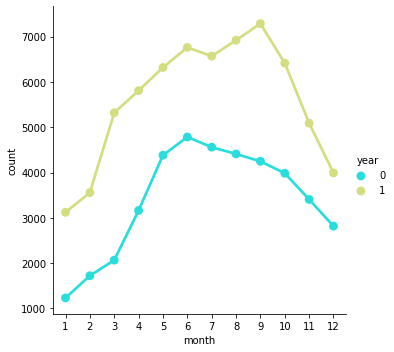

In [17]:
# Plot trend
sns.catplot(col_month,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')

#### 2.6 Plot relation between temperature and number of rented bikes

* Make sure data is plausible
* Expected plot contains one peak (optimal biking temperature)

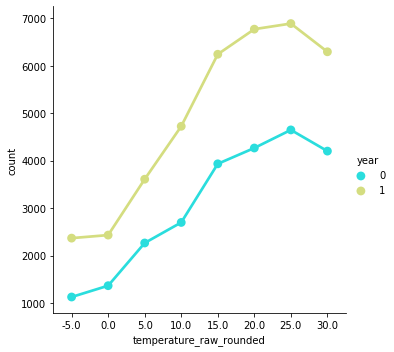

In [18]:
# Plot trend
sns.catplot(col_temperature_raw_rounded,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')

#### 2.7 Plot relation between weather situation and number of rented bikes

* Make sure data is plausible
* Expected plot indicates that there are significantly more rentals on day having good weather (clear or misty) 
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

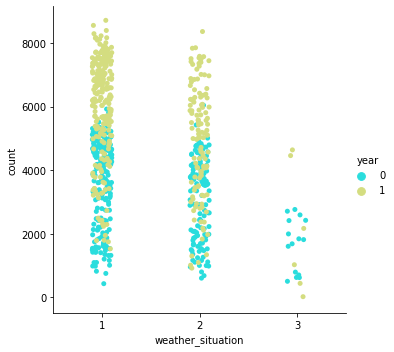

In [19]:
# Plot trend
sns.catplot(col_weather_situation,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='strip', palette='rainbow')

#### 2.8 Plot relation between weather situation and number of rented bikes

* Make sure data is plausible
* Expected plot indicates that more bikes are rented during day time
  * Probably there are two peeks when people go to work / go back home

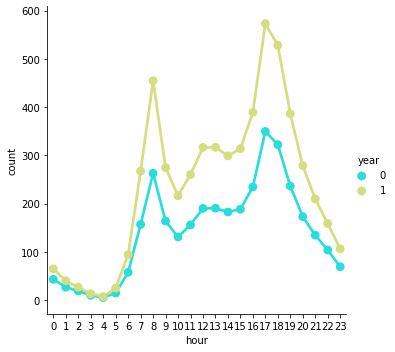

In [20]:
# Plot trend
sns.catplot(col_hour,col_count,hue=col_year,data=data_sets[data_set_hour].data_frame, ci=None, kind='point', palette='rainbow')

#### 2.9 Plot correlation matrix of some attributes

* Expected matrix contains the following correlations
  * strong correlation between _temperature_ and _apparent temperature_

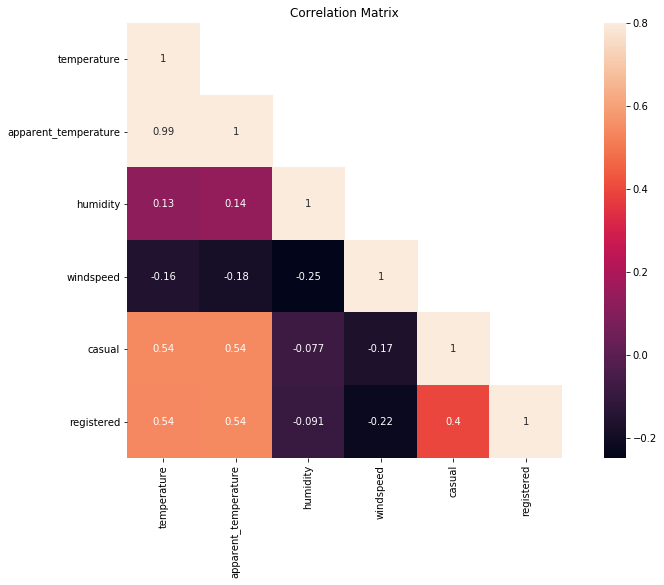

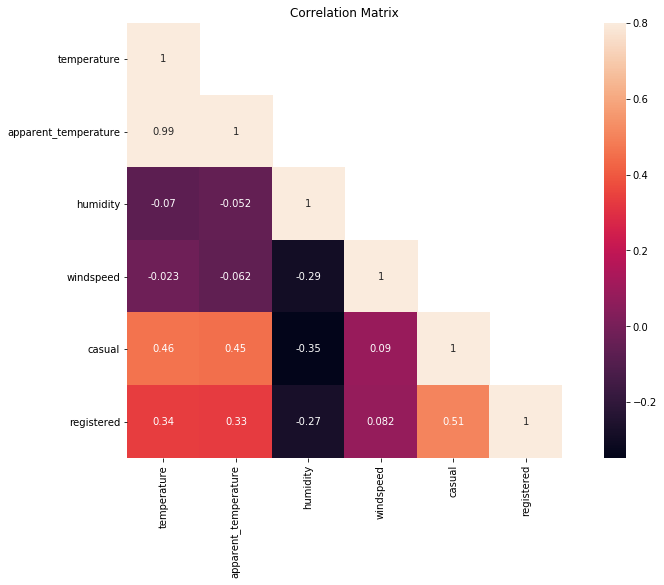

In [21]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Plot correlation matrix
    correlationMatrix=data_set.data_frame[[col_temperature, col_apparent_temperature, col_humidity,col_windspeed,
                                           col_casual, col_registered]].corr()
    mask=np.array(correlationMatrix)
    mask[np.tril_indices_from(mask)]=False
    
    fig,ax=plt.subplots(figsize=(15,8))
    sns.heatmap(correlationMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
    ax.set_title('Correlation Matrix')
    plt.show()

## 3 Hypotheses

Based on the basic understanding of the data sets two hypotheses shall be made

In the course of this notebook the data sets will be extended by additional information
* days since start of the bike sharing campaign
* weather conditions of previous period

### 3.1 Hypothesis A

There is a significant difference in the number of rented bikes in the two years being contained in the data set. 
Therefore it can be assumed that the raising popularity correlates with the number of rented bikes.
In order to include this assumption a synthentic feature ```days since start``` shall be used.

*Hypthesis* Taking into account the number of days since the bike sharing campaign has started will increase the 
performance of the model.

### 3.2 Hypothesis B

Different aspects of the weather affect how many bikes are rented. In most cases there may be time between _deciding to 
use a shared bike_ and _actually using a shared bike_. Therefore also the weather conditions of the time period 
_before_ a bike is rented may be relevant. In order to achieve this some sythethic features such as 
```weather_situation_hist```, ```temperature_hist```, ```apparent_temperature_hist```, ```humidity_hist```, 
```windspeed_hist``` shall be included.

*Hypthesis* Taking into account the weather conditions of the previous period will increase the 
performance of the model.

### 3.3 Hypothesis C

Features temperature and apparent temperature strongly correlate with each other. It is to be assumed that dropping one 
of the two does not reduce model performance.

*Hypthesis* Dropping _apparent temperature_ does not decrease performance of the model.

## 4 Preprocess data

### 4.1 Initialize variants

Three variants will be trained and evaluated
* ```original``` original data frame
* ```market``` original data frame + days since start
* ```history``` original data frame + history weather conditions
* ```reduced``` original data frame + manual dimensionality reduction

In [22]:
# Variants
variant_original = "original"
variant_market = "market"
variant_history = "history"
variant_reduced = "reduced"

class Variant:
    """Contains data, model and predictions of a variant"""
    color = "#000"
    data_frame = {}
    folds = {}
    models = {}
    
    def __init__(self, color):
        self.color = color

In [23]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Assign variants to data frames
    data_set.variants = {
        variant_original: Variant(color="#d4dd80"),
        variant_market: Variant(color="#3fe0e0"),
        variant_history: Variant(color="#3fb5e0"),
        variant_reduced: Variant(color="red"),
    }

### 4.2 One-hot-encode categorical data

In [24]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # One-hot encode columns 
    for column in data_set.columns_categorical:
        data_set.data_frame = pd.concat([data_set.data_frame,pd.get_dummies(data_set.data_frame[column], prefix=column)],axis=1)

### 4.3 Enhance data

* The following variants shall be compared
  * _original_ original features
  * _market_ original features + time since start of bike sharing campaign

In [25]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Copy original data frame
        variant.data_frame = data_set.data_frame.copy()

#### 4.3.1 Variant _market_

In [26]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Calculate days since start
    start_date = data_set.variants[variant_market].data_frame[col_datetime].min()
    data_set.variants[variant_market].data_frame[col_days_since_start_raw] = \
        data_set.variants[variant_market].data_frame.apply(lambda row: (row[col_datetime] - start_date).days, axis = 1) 
    
    # Normalize days since start
    max_days_since_start = data_set.variants[variant_market].data_frame[col_days_since_start_raw].max()
    data_set.variants[variant_market].data_frame[col_days_since_start] = \
        data_set.variants[variant_market].data_frame.apply(lambda row: (row[col_days_since_start_raw] / max_days_since_start), axis = 1)
    
    # Drop raw days since start
    data_set.variants[variant_market].data_frame.drop(col_days_since_start_raw, axis=1, inplace=True)

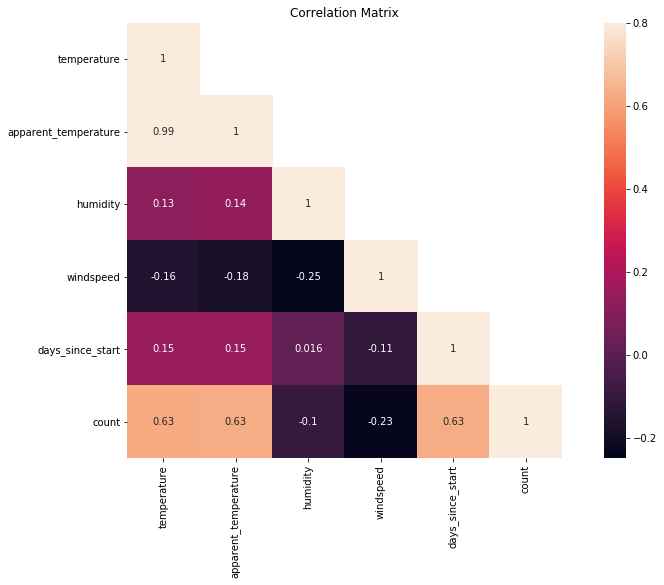

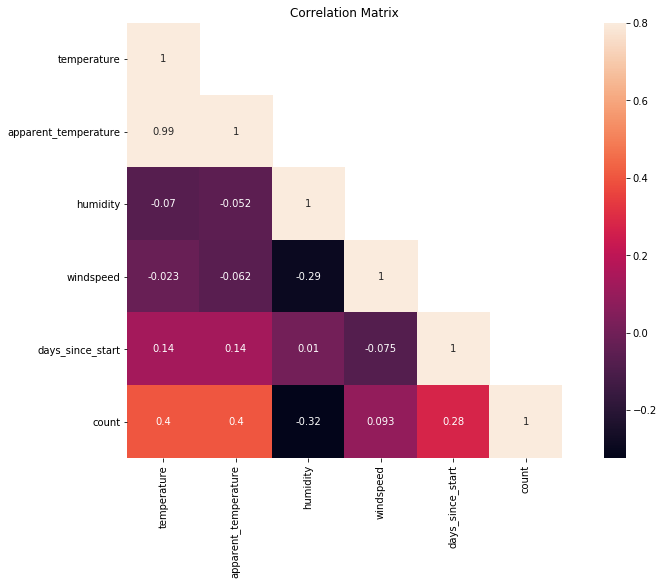

In [27]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Plot correlation matrix
    correlationMatrix=data_set.variants[variant_market].data_frame[[col_temperature, col_apparent_temperature, 
                                                                    col_humidity, col_windspeed, col_days_since_start, 
                                                                    col_count]].corr()
    mask=np.array(correlationMatrix)
    mask[np.tril_indices_from(mask)]=False
    
    fig,ax=plt.subplots(figsize=(15,8))
    sns.heatmap(correlationMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
    ax.set_title('Correlation Matrix')
    plt.show()

#### 4.3.2 Variant _history_

In [28]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Copy columns into hist columns
    data_set.variants[variant_history].data_frame[col_weather_situation_hist] = data_set.variants[variant_history].data_frame[col_weather_situation]
    data_set.variants[variant_history].data_frame[col_temperature_hist] = data_set.variants[variant_history].data_frame[col_temperature]
    data_set.variants[variant_history].data_frame[col_apparent_temperature_hist] = data_set.variants[variant_history].data_frame[col_apparent_temperature]
    data_set.variants[variant_history].data_frame[col_humidity_hist] = data_set.variants[variant_history].data_frame[col_humidity]
    data_set.variants[variant_history].data_frame[col_windspeed_hist] = data_set.variants[variant_history].data_frame[col_windspeed]
    
    # Shift hist columns by 1
    data_set.variants[variant_history].data_frame[col_weather_situation_hist].shift(1)
    data_set.variants[variant_history].data_frame[col_temperature_hist].shift(1)
    data_set.variants[variant_history].data_frame[col_apparent_temperature_hist].shift(1)
    data_set.variants[variant_history].data_frame[col_humidity_hist].shift(1)
    data_set.variants[variant_history].data_frame[col_windspeed_hist].shift(1)
    
    # One-hot encode columns 
    data_set.variants[variant_history].data_frame = pd.concat([data_set.variants[variant_history].data_frame,
                                                               pd.get_dummies(data_set.variants[variant_history].data_frame[col_weather_situation_hist], 
                                                                              prefix=col_weather_situation_hist)],axis=1)
    # Drop one-hot encoded columns
    data_set.variants[variant_history].data_frame.drop([col_weather_situation_hist], axis=1, inplace=True)

#### 4.3.3 Variant _reduced_

In [29]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_season + "_")), axis=1, inplace=True)
    data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex="^" + col_apparent_temperature + "$")), axis=1, inplace=True)
    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_weekday + "_")), axis=1, inplace=True)
    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_month + "_")), axis=1, inplace=True)
    
# data_sets[data_set_day].variants[variant_reduced].data_frame.head()

### 4.4 Normalize data

Nothing to be done here since features are already normalized.

### 4.5 Drop columns

* The following columns need to be dropped
  * Indices
    * _instant_ since it does not contain any information besides the order
  * Columns which cannot be used directly
    * _datetime_ which is formatted ```yyyy-mm-dd```
  * Columns which are one-hot encoded
  * Columns which contain raw values
  * Unused target columns

In [30]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Drop index and unusable columns
        variant.data_frame.drop([col_instant, col_datetime], axis=1, inplace=True)
        # Drop one-hot encoded columns
        variant.data_frame.drop(data_set.columns_categorical, axis=1, inplace=True)
        # Drop raw-value columns
        variant.data_frame.drop(columns_raw_values, axis=1, inplace=True)
        # Drop unused target columns    
        variant.data_frame.drop([col_casual, col_registered], axis=1, inplace=True)

## 5 Split data into _training_ and _test_

In [31]:
class DataSplit:
    """Contains results of a train/test data split"""
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

In [32]:
data_sets[data_set_day].variants[variant_original].data_frame.head()

,temperature,apparent_temperature,humidity,windspeed,count,season_1,season_2,season_3,season_4,year_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_situation_1,weather_situation_2,weather_situation_3
0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
1,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0
4,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0


In [33]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Define columns
        data_bike_x = variant.data_frame.drop([col_count], axis=1)
        data_bike_y = variant.data_frame[[col_count]]
        
        n_splits = 5
        test_size = 0.3
        random_state = 0
        
        # Initialize KFold
        kf = KFold(n_splits=n_splits, random_state=random_state)
        
        fold_index = 0
        for train_index, test_index in kf.split(data_bike_x):
        
            x_train, x_test = data_bike_x.iloc[train_index], data_bike_x.iloc[test_index]
            y_train, y_test = data_bike_y.iloc[train_index], data_bike_y.iloc[test_index]
        
            # Split training data and test data
            # x_train, x_test, y_train, y_test = train_test_split(data_bike_day_x, data_bike_day_y, test_size=test_size, random_state=random_state)
            
            # Add splitted data 
            variant.folds["Fold " + str(fold_index)] = DataSplit(x_train, x_test, y_train, y_test)  
            
            # Show splitted data
            # print("data set" + data_set_name + " / variant " + variant_name + " / fold "  + str(fold_index) + " / " + str(x_train.shape) + ", " + str(x_test.shape) + ", " + str(y_train.shape) + ", " + str(y_test.shape))

            fold_index += 1
            

## 6 Initialize model

In [34]:
# Put models into dictionary
models = {
    "Linear Regression": LinearRegression(),
    # "Decision Tree Regressor (25)": DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=25),
    # "Decision Tree Regressor (50)": DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=50),
    # "Decision Tree Regressor (100)": DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=100),
    "Decision Tree Regressor (200)": DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=200),
    # "Random Forest Regressor (25)": RandomForestRegressor(n_estimators=25),
    # "Random Forest Regressor (50)": RandomForestRegressor(n_estimators=50),
    # "Random Forest Regressor (100)": RandomForestRegressor(n_estimators=100),
    "Random Forest Regressor (200)": RandomForestRegressor(n_estimators=200),
    # "Lasso (0.2)": Lasso(alpha=0.2),
    # "Lasso (0.4)": Lasso(alpha=0.4),
    # "Lasso (0.6)": Lasso(alpha=0.6),
    # "Lasso (0.8)": Lasso(alpha=0.8),
    "Lasso (1.0)": Lasso(alpha=1.0),
    "Elastic Net (0.2)": ElasticNet(alpha=0.2, random_state=0),
    "Elastic Net (0.4)": ElasticNet(alpha=0.4, random_state=0),
    "Elastic Net (0.6)": ElasticNet(alpha=0.6, random_state=0),
    "Elastic Net (0.8)": ElasticNet(alpha=0.8, random_state=0),
    "Elastic Net (1.0)": ElasticNet(alpha=1.0, random_state=0),
    # "Ridge (0.2)": Ridge(alpha=0.2),
    # "Ridge (0.4)": Ridge(alpha=0.4),
    # "Ridge (0.6)": Ridge(alpha=0.6),
    # "Ridge (0.8)": Ridge(alpha=0.8),
    "Ridge (1.0)": Ridge(alpha=1.0),
    "Support Vector Regression (linear)": SVR(kernel='linear', gamma='scale', C=1.0, epsilon=0.2),
    "Support Vector Regression (rbf)": SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2),
    "Support Vector Regression (poly)": SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2),
    "Support Vector Regression (sigmoid)": SVR(kernel='sigmoid', gamma='scale', C=1.0, epsilon=0.2),
}

In [35]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
    
        # Iterate over models
        for model_name, model in models.items():
            
            # Attach model to variant
            variant.models[model_name] = model

## 7 Train and evaluate model

In [38]:
def trainAndEvaluateDataSet(data_set_name, data_set):
    """Trains and evaluates a given data set"""
    
    variant_index = 0
    y_pos = np.arange(len(models.keys()))
    handles = []
    
    plt.figure(figsize=(10,10))

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        print(variant_name)
        
        model_index = 0
        metric_r2_score_list = []
        
        # Iterate over models in variant 
        for model_name, model in variant.models.items():
                        
            start = time.time()
            
            # Initialize metric
            metric_explained_variance_score = 0
            metric_max_error = 0
            metric_mean_absolute_error = 0
            metric_mean_squared_error = 0
            metric_median_absolute_error = 0
            metric_r2_score = 0
            
            for fold_name, fold in variant.folds.items():
            
                # Fit model and create prediction
                model.fit(fold.x_train, fold.y_train)
                
                # Make prediction
                predicted_values = model.predict(fold.x_test)
                expected_values = fold.y_test
                
                # Calculate scores
                metric_explained_variance_score += explained_variance_score(expected_values, predicted_values)
                metric_max_error += max_error(expected_values, predicted_values)
                metric_mean_absolute_error += mean_absolute_error(expected_values, predicted_values)
                metric_mean_squared_error += mean_squared_error(expected_values, predicted_values)
                metric_median_absolute_error += median_absolute_error(expected_values, predicted_values)
                metric_r2_score += r2_score(expected_values, predicted_values)
                
                # print("explained variance score", round(metric_explained_variance_score, 2))
                # print("               max error", round(metric_max_error, 2))
                # print("     mean absolute error", round(metric_mean_absolute_error, 2))
                # print("      mean squared error", round(metric_mean_squared_error, 2))
                # print("   median absolute error", round(metric_median_absolute_error, 2))
                # print("                r2 score", round(metric_r2_score, 2))
            
            fold_count = len(variant.folds.items())
            
            # Divide scores by number of folds
            metric_explained_variance_score /= fold_count
            metric_max_error /= fold_count
            metric_mean_absolute_error /= fold_count
            metric_mean_squared_error /= fold_count
            metric_median_absolute_error /= fold_count
            metric_r2_score /= fold_count
            
            end = time.time()
            print("  (" + str(round(end-start, 2)) + "s)\t" + model_name + " > " + str(round(metric_r2_score, 2)))

            metric_r2_score_list.insert(model_index, metric_r2_score)
            model_index += 1
            
        print("")
        
        handle = plt.barh(y_pos + (0.8 * variant_index / len(data_set.variants)), metric_r2_score_list, 0.8 * 1/len(data_set.variants), align='center', alpha=0.5, color=variant.color, label=variant_name)
        handles.insert(variant_index, handle)
        variant_index += 1
    
    plt.xlabel('R2 Score')
    plt.yticks(y_pos, models.keys())
    plt.title('Model performance')
    plt.legend(handles=handles)
    plt.show()
    

### 7.1 Data Set _day_

In [ ]:
# Train and evaluate data set 'day'
trainAndEvaluateDataSet(data_set_day, data_sets[data_set_day])   

original
  (0.21s)	Linear Regression > 0.54
  (0.56s)	Decision Tree Regressor (200) > 0.58
  (88.13s)	Random Forest Regressor (200) > 0.79
  (0.22s)	Lasso (1.0) > 0.57
  (0.18s)	Elastic Net (0.2) > 0.37
  (0.17s)	Elastic Net (0.4) > 0.21
  (0.18s)	Elastic Net (0.6) > 0.12
  (0.15s)	Elastic Net (0.8) > 0.06
  (0.17s)	Elastic Net (1.0) > 0.01
  (0.14s)	Ridge (1.0) > 0.54
  (79.23s)	Support Vector Regression (linear) > 0.55
  (110.33s)	Support Vector Regression (rbf) > 0.26
  (84.48s)	Support Vector Regression (poly) > 0.38
  (100.18s)	Support Vector Regression (sigmoid) > 0.29

market
  (0.2s)	Linear Regression > 0.54
  (0.57s)	Decision Tree Regressor (200) > 0.58
  (89.54s)	Random Forest Regressor (200) > 0.79
  (0.2s)	Lasso (1.0) > 0.57
  (0.18s)	Elastic Net (0.2) > 0.37
  (0.17s)	Elastic Net (0.4) > 0.21
  (0.16s)	Elastic Net (0.6) > 0.12
  (0.16s)	Elastic Net (0.8) > 0.06
  (0.15s)	Elastic Net (1.0) > 0.01
  (0.11s)	Ridge (1.0) > 0.54
  (85.4s)	Support Vector Regression (linear) > 0.

### 7.2 Data Set _hour_

In [ ]:
# Train and evaluate data set 'hour'
trainAndEvaluateDataSet(data_set_hour, data_sets[data_set_hour])

## 8 Conclusion

### 3.1 Hypothesis A

### 3.2 Hypothesis B

### 3.3 Hypothesis C